In [33]:
# Importing required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, avg, when, dayofweek, month
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Classification_Task") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.local.dir", "E:/SparkTemp") \
    .getOrCreate()

In [35]:
# Load Dataset from Local File System
data_path = r"C:\\hadoop_doc\\Online_Retail.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [36]:
# View the first few rows
df.show(5)  

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [37]:
'''# Checking data types
df.printSchema()'''


'# Checking data types\ndf.printSchema()'

In [38]:
# Data Cleaning
df = df.dropna().filter(col("Quantity") > 0).filter(col("UnitPrice") > 0)


In [39]:
# Feature Engineering
df = df.withColumn("TotalAmount", col("Quantity") * col("UnitPrice")) 
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|       TotalAmount|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|    

In [40]:
# Calculating total spend per customer
spending_df = df.groupBy("CustomerID").agg(sum("TotalAmount").alias("Total_Spend"))
median_spend = spending_df.approxQuantile("Total_Spend", [0.5], 0.0)[0]
spending_df = spending_df.withColumn("HighValueCustomer", when(col("Total_Spend") > median_spend, 1).otherwise(0))


In [41]:
# Compute features for model training
customer_features = df.groupBy("CustomerID").agg(
    count("InvoiceNo").alias("Purchase_Frequency"),
    avg("TotalAmount").alias("Avg_Order_Value")
)

df = df.withColumn("Purchase_Day", dayofweek(col("InvoiceDate")))
df = df.withColumn("Purchase_Month", month(col("InvoiceDate")))

time_features = df.groupBy("CustomerID").agg(
    avg("Purchase_Day").alias("Avg_Purchase_Day"),
    avg("Purchase_Month").alias("Avg_Purchase_Month")
)
customer_features = customer_features.join(time_features, on="CustomerID", how="inner")

In [42]:
# Merge features with target label
customer_df = customer_features.join(spending_df, on="CustomerID", how="inner")


In [43]:
# Vector Assembling
feature_cols = ["Purchase_Frequency", "Avg_Order_Value", "Avg_Purchase_Day"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
customer_df = assembler.transform(customer_df)



In [44]:
# Train-Test Split
train_df, test_df = customer_df.randomSplit([0.8, 0.2], seed=42)

In [45]:
# Feature Scaling
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_df)
train_df = scaler_model.transform(train_df)
test_df = scaler_model.transform(test_df)

In [46]:
# Train and applying Random Forest Model
rf_classifier = RandomForestClassifier(labelCol="HighValueCustomer", featuresCol="scaledFeatures")
rf_model = rf_classifier.fit(train_df)
rf_predictions = rf_model.transform(test_df)


In [47]:
# Train and applying Logistic Regression Model
lr_classifier = LogisticRegression(labelCol="HighValueCustomer", featuresCol="scaledFeatures")
lr_model = lr_classifier.fit(train_df)
lr_predictions = lr_model.transform(test_df)

In [48]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="HighValueCustomer", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Random Forest Accuracy: 0.9549
Logistic Regression Accuracy: 0.8331


In [10]:
# Convert Predictions to Pandas for Visualization
rf_predictions_pandas = rf_predictions.select("HighValueCustomer", "prediction").toPandas()
lr_predictions_pandas = lr_predictions.select("HighValueCustomer", "prediction").toPandas()


In [ ]:
# Convert Predictions to Pandas for Visualization
rf_predictions_pandas = rf_predictions.select("HighValueCustomer", "prediction").toPandas()
# Plot Confusion Matrices
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Value (0)", "High Value (1)"],
            yticklabels=["Low Value (0)", "High Value (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()


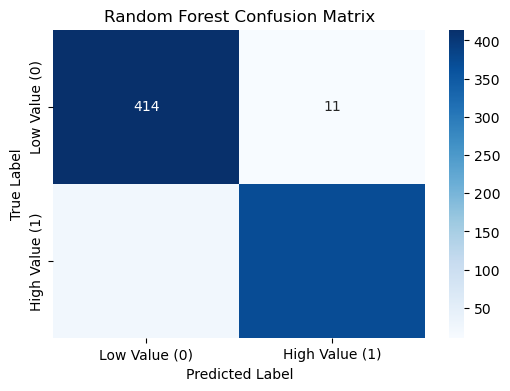

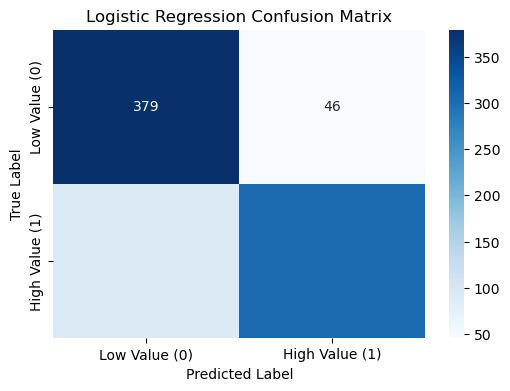

In [11]:
# Compute Confusion Matrix
rf_conf_matrix = confusion_matrix(rf_predictions_pandas["HighValueCustomer"], rf_predictions_pandas["prediction"])
lr_conf_matrix = confusion_matrix(lr_predictions_pandas["HighValueCustomer"], lr_predictions_pandas["prediction"])

# Plot Confusion Matrices
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Value (0)", "High Value (1)"],
            yticklabels=["Low Value (0)", "High Value (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Value (0)", "High Value (1)"],
            yticklabels=["Low Value (0)", "High Value (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Computing Precision, Recall, and F1-score for Random Forest
rf_classification_report = classification_report(
    rf_predictions_pandas["HighValueCustomer"], 
    rf_predictions_pandas["prediction"]
)
print("Random Forest - Classification Report:\n", rf_classification_report)

# Compute Precision, Recall, and F1-score for Logistic Regression
lr_classification_report = classification_report(
    lr_predictions_pandas["HighValueCustomer"], 
    lr_predictions_pandas["prediction"]
)
print("Logistic Regression - Classification Report:\n", lr_classification_report)


Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       425
           1       0.97      0.94      0.95       396

    accuracy                           0.96       821
   macro avg       0.96      0.96      0.96       821
weighted avg       0.96      0.96      0.96       821

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       425
           1       0.87      0.77      0.82       396

    accuracy                           0.83       821
   macro avg       0.84      0.83      0.83       821
weighted avg       0.84      0.83      0.83       821



In [ ]:

# Stop Spark Session
spark.stop()
